# Next-Frame Video Prediction with Convolutional LSTMs

## Introduction

The
[Convolutional LSTM](https://papers.nips.cc/paper/2015/file/07563a3fe3bbe7e3ba84431ad9d055af-Paper.pdf)
architectures bring together time series processing and computer vision by
introducing a convolutional recurrent cell in a LSTM layer. In this example, we will explore the
Convolutional LSTM model in an application to next-frame prediction, the process
of predicting what video frames come next given a series of past frames.

## Setup

In [2]:
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
os.chdir("/content/drive/MyDrive")

In [5]:
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras import layers

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox

## Dataset Construction

For this example, we will be using the
[Moving MNIST](http://www.cs.toronto.edu/~nitish/unsupervised_video/)
dataset.

We will download the dataset and then construct and
preprocess training and validation sets.

For next-frame prediction, our model will be using a previous frame,
which we'll call `f_n`, to predict a new frame, called `f_(n + 1)`.
To allow the model to create these predictions, we'll need to process
the data such that we have "shifted" inputs and outputs, where the
input data is frame `x_n`, being used to predict frame `y_(n + 1)`.

In [6]:
%%time

# Download and load the dataset.
fpath = keras.utils.get_file(
    "moving_mnist.npy",
    "http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy",
)
dataset = np.load(fpath)

# Swap the axes representing the number of frames and number of data samples.
dataset = np.swapaxes(dataset, 0, 1)
# We'll pick out 1000 of the 10000 total examples and use those.
dataset = dataset[:1000, ...]
# Add a channel dimension since the images are grayscale.
dataset = np.expand_dims(dataset, axis=-1)

# Split into train and validation sets using indexing to optimize memory.
indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.9 * dataset.shape[0])]
val_index = indexes[int(0.9 * dataset.shape[0]) :]
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]

# Normalize the data to the 0-1 range.
train_dataset = train_dataset / 255
val_dataset = val_dataset / 255


# We'll define a helper function to shift the frames, where
# `x` is frames 0 to n - 1, and `y` is frames 1 to n.
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y


# Apply the processing function to the datasets.
x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)

# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

819200096/819200096 [==============================] - 15s 0us/step
Training Dataset Shapes: (900, 19, 64, 64, 1), (900, 19, 64, 64, 1)
Validation Dataset Shapes: (100, 19, 64, 64, 1), (100, 19, 64, 64, 1)
CPU times: user 1.76 s, sys: 2.65 s, total: 4.41 s
Wall time: 16 s


## Data Visualization

Our data consists of sequences of frames, each of which
are used to predict the upcoming frame. Let's take a look
at some of these sequential frames.

Displaying frames for example 151.


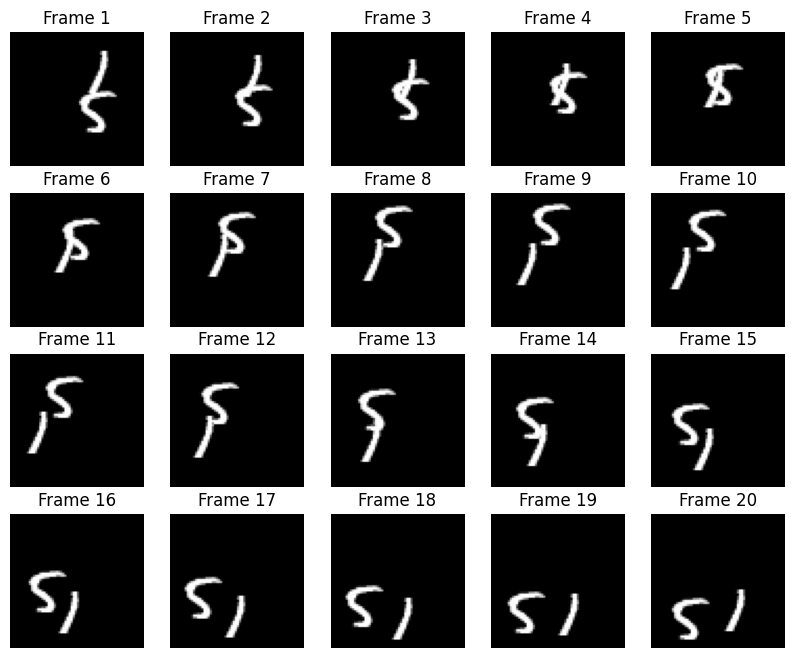

CPU times: user 987 ms, sys: 213 ms, total: 1.2 s
Wall time: 983 ms


In [7]:
%%time

# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(4, 5, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(train_dataset[data_choice][idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()

## Model Construction

To build a Convolutional LSTM model, we will use the
`ConvLSTM2D` layer, which will accept inputs of shape
`(batch_size, num_frames, width, height, channels)`, and return
a prediction movie of the same shape.

In [8]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

class SelfAttention(layers.Layer):
    def __init__(self, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.query_dense = layers.Dense(units=input_shape[-1])
        self.key_dense = layers.Dense(units=input_shape[-1])
        self.value_dense = layers.Dense(units=input_shape[-1])
        self.combine_heads = layers.Dense(units=input_shape[-1])

    def call(self, inputs):
        # Generate query, key, value tensors
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        # Calculate attention scores
        scores = tf.matmul(query, key, transpose_b=True)
        distribution = tf.nn.softmax(scores)
        attention_output = tf.matmul(distribution, value)

        # Combine heads and add residual connection
        combined_output = self.combine_heads(attention_output) + inputs
        return combined_output

In [9]:
# input shape
(None, *x_train.shape[2:])

(None, 64, 64, 1)

In [10]:
from typing import Tuple
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

def vapaad(input_shape: Tuple[int, int, int], image_size: int = 64) -> keras.Model:
    """
    Builds a video processing model with data augmentation and self-attention mechanisms.

    Args:
        input_shape (Tuple[int, int, int]): The shape of the input frames.
        image_size (int, optional): The target size to resize the frames. Defaults to 64.

    Returns:
        keras.Model: A compiled keras model ready for training.
    """
    # Initialize the data augmentation pipeline
    data_augmentation = keras.Sequential([
        # layers.RandomFlip("horizontal"),  # Randomly flip frames horizontally
        layers.RandomRotation(factor=0.02),  # Randomly rotate frames by a small angle
        # layers.RandomZoom(height_factor=0.1, width_factor=0.1),  # Randomly zoom in on frames
    ], name="data_augmentation")

    inp = layers.Input(shape=input_shape)  # Define the input layer with the specified shape

    # Apply data augmentation to each frame using the TimeDistributed layer
    x = layers.TimeDistributed(data_augmentation)(inp)

    # First ConvLSTM2D layer with self-attention
    x = layers.ConvLSTM2D(filters=64, kernel_size=(5, 5), padding="same", return_sequences=True, activation="relu")(x)
    x = layers.BatchNormalization()(x)  # Normalize the activations of the first layer
    x = SelfAttention()(x)  # Apply self-attention mechanism

    # Second ConvLSTM2D layer with self-attention
    x = layers.ConvLSTM2D(filters=64, kernel_size=(3, 3), padding="same", return_sequences=True, activation="relu")(x)
    x = layers.BatchNormalization()(x)  # Normalize the activations of the second layer
    x = SelfAttention()(x)  # Apply self-attention mechanism

    # Third ConvLSTM2D layer with self-attention
    x = layers.ConvLSTM2D(filters=64, kernel_size=(1, 1), padding="same", return_sequences=True, activation="relu")(x)
    x = SelfAttention()(x)  # Apply self-attention mechanism

    # Final Conv3D layer to produce the output
    x = layers.Conv3D(filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same")(x)

    # Create the model
    model = keras.models.Model(inputs=inp, outputs=x)

    # Return
    return model

In [11]:
# Example usage:
# Assuming x_train.shape is (900, 19, 64, 64, 1), indicating (samples, frames, height, width, channels)
model = vapaad(input_shape=(None, *x_train.shape[2:]))

In [12]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='mean_squared_error'
)

# Display the model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 64, 64, 1   0         
                             )]                                  
                                                                 
 time_distributed (TimeDist  (None, None, 64, 64, 1)   0         
 ributed)                                                        
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, None, 64, 64, 64   416256    
                             )                                   
                                                                 
 batch_normalization (Batch  (None, None, 64, 64, 64   256       
 Normalization)              )                                   
                                                                 
 self_attention (SelfAttent  (None, None, 64, 64, 64   16640 

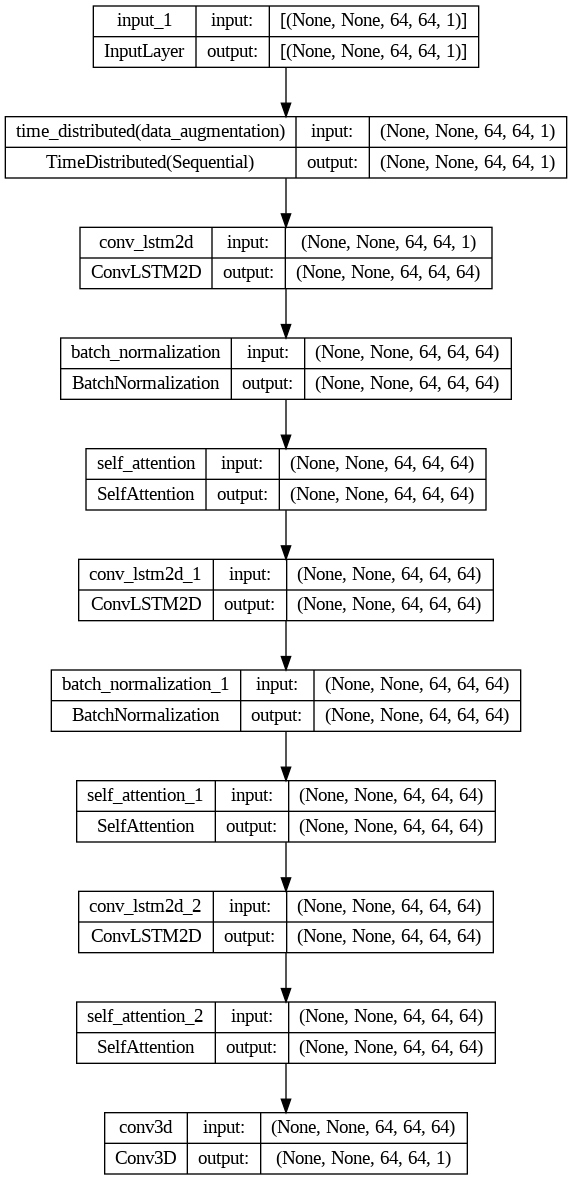

In [13]:
tf.keras.utils.plot_model(model, show_shapes=True)

## Model Training

With our model and data constructed, we can now train the model.

In [14]:
import tensorflow as tf

In [15]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [16]:
class PrintLR(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        if hasattr(lr, "value"):
            lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
            print(f"\nEpoch {epoch + 1}: Learning rate is {lr:.6f}.")

print_lr = PrintLR()

In [17]:
from tensorflow.keras.callbacks import LearningRateScheduler

# Define a simple step decay schedule
def step_decay_schedule(epoch, lr):
    """
    Learning rate scheduler that implements a step decay schedule.

    Args:
        epoch (int): The current epoch number.
        lr (float): The current learning rate.

    Returns:
        float: The adjusted learning rate.
    """
    initial_lr = 0.001  # Starting learning rate
    drop = 0.7  # Factor by which to drop the learning rate
    epochs_drop = 10.0  # Drop the learning rate every 'epochs_drop' epochs
    new_lr = initial_lr * (drop ** np.floor((1+epoch)/epochs_drop))
    return new_lr

# Create the LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(schedule=step_decay_schedule, verbose=1)

In [ ]:
%%time

# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=100)
# reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 15
batch_size = 5

# Fit the model to the training data.
with tf.device('/device:GPU:0'):
    model.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_val, y_val),
        callbacks=[early_stopping, lr_scheduler, print_lr],
    )


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/15
180/180 [==============================] - ETA: 0s - loss: 0.0432
Epoch 1: Learning rate is 0.001000.
180/180 [==============================] - 165s 841ms/step - loss: 0.0432 - val_loss: 0.0643 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/15
180/180 [==============================] - ETA: 0s - loss: 0.0381
Epoch 2: Learning rate is 0.001000.
180/180 [==============================] - 154s 855ms/step - loss: 0.0381 - val_loss: 0.0662 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/15
180/180 [==============================] - ETA: 0s - loss: 0.0364
Epoch 3: Learning rate is 0.001000.
180/180 [==============================] - 154s 856ms/step - loss: 0.0364 - val_loss: 0.0649 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/15
180/180 [==============================] - ETA: 0s - loss: 0.0360
Epoch 4: L

## A Siamese Network: Instructor Model

In [ ]:
from tensorflow.keras import layers, models, Input
import tensorflow as tf

In [ ]:
def create_conv_lstm_branch(input_shape, idx=1):
    inp = Input(shape=input_shape)
    x = layers.TimeDistributed(layers.Conv2D(64, (3, 3), activation="relu", padding="same"))(inp)
    x = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(x)
    x = layers.ConvLSTM2D(filters=64, kernel_size=(3, 3), padding="same", return_sequences=True, activation="relu")(x)
    x = SelfAttention()(x)
    x = layers.GlobalAveragePooling3D()(x)
    return models.Model(inputs=inp, outputs=x, name=f"conv_lstm_branch_{idx}")

In [ ]:
def instructor_model_with_vapaad(input_shape=(None, 64, 64, 1), a_trained_vapaad_model=model):
    # Define the input layers
    input_a = Input(shape=input_shape, name="sequence_a")
    input_b = Input(shape=input_shape, name="sequence_b")

    # Initialize the vapaad model for preprocessing
    vapaad_branch = a_trained_vapaad_model

    # Process both inputs with the vapaad model first
    processed_a = vapaad_branch(input_a)
    # processed_b = vapaad_branch(input_b)  # Now input_b also goes through vapaad

    # Ensure that the vapaad model's output is suitable for the ConvLSTM layer
    # This may require adjusting the vapaad model or adding additional layers here

    # The ConvLSTM and self-attention structure is now applied to both processed_a and processed_b
    conv_lstm_branch_a = create_conv_lstm_branch(input_shape, idx=1)  # Assuming create_conv_lstm_branch can handle the output shape from vapaad
    conv_lstm_branch_b = create_conv_lstm_branch(input_shape, idx=2)  # Creating a separate branch for input_b for clarity

    processed_a = conv_lstm_branch_a(processed_a)
    processed_b = conv_lstm_branch_b(input_b)

    # Concatenate the outputs of the two branches
    concatenated = layers.concatenate([processed_a, processed_b], axis=-1)

    # Dense layers after concatenation
    x = layers.Dense(64, activation="relu")(concatenated)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(32, activation="relu")(x)
    x = layers.Dense(19, activation="sigmoid")(x)

    # Create the instructor model with integrated vapaad branch
    return models.Model(inputs=[input_a, input_b], outputs=x, name="instructor_model_with_vapaad")

In [ ]:
(None, *x_train.shape[2:])

In [ ]:
# Assuming x_train.shape is defined and compatible with the models
# You would replace *x_train.shape[2:] with the actual shape dimensions when calling this function.
inst_model = instructor_model_with_vapaad(input_shape=(None, *x_train.shape[2:]))

# Model summary to inspect the architecture
inst_model.summary()

In [ ]:
tf.keras.utils.plot_model(inst_model, show_shapes=True)

In [ ]:
x_train.shape, y_train.shape

In [ ]:
y_train_pred = model.predict(x_train)
y_train_pred.shape

In [ ]:
# Calculate the mean squared error (MSE) for each sequence, resulting in shape (900, 19, 1)
y_truth_pred_diff = np.mean((y_train - y_train_pred) ** 2, axis=(2, 3, 4), keepdims=True).reshape(-1, 19)

# The resulting shape should be (900, 19, 1) as intended
print(y_truth_pred_diff.shape)

In [ ]:
y_truth_pred_diff = np.zeros((900, 19))
print(y_truth_pred_diff.shape)

In [ ]:
# Compiler
inst_model.compile(
    optimizer='adam',
    loss='mean_squared_error'
)

In [ ]:
x_train.shape, y_train_pred.shape, y_truth_pred_diff.shape

In [ ]:
%%time

# Define modifiable training hyperparameters.
epochs = 10
batch_size = 5

# Fit the model to the training data.
with tf.device('/device:GPU:0'):
    inst_model.fit(
        [x_train, y_train],
        y_truth_pred_diff,
        batch_size=batch_size,
        epochs=epochs,
        validation_split=0.1,
        callbacks=[early_stopping, lr_scheduler, print_lr],
    )

## Frame Prediction Visualizations

With our model now constructed and trained, we can generate
some example frame predictions based on a new video.

We'll pick a random example from the validation set and
then choose the first ten frames from them. From there, we can
allow the model to predict 10 new frames, which we can compare
to the ground truth frame predictions.

In [ ]:
# Select a random example from the validation dataset.
example = val_dataset[np.random.choice(range(len(val_dataset)), size=1)[0]]

# Pick the first/last ten frames from the example.
frames = example[:10, ...]
original_frames = example[10:, ...]

# Predict a new set of 10 frames.
for _ in range(10):
    # Extract the model's prediction and post-process it.
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    # Extend the set of prediction frames.
    frames = np.concatenate((frames, predicted_frame), axis=0)

# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Plot the new frames.
new_frames = frames[10:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Display the figure.
plt.show()

## Predicted Videos

Finally, we'll pick a few examples from the validation set
and construct some GIFs with them to see the model's
predicted videos.

You can use the trained model hosted on [Hugging Face Hub](https://huggingface.co/keras-io/conv-lstm)
and try the demo on [Hugging Face Spaces](https://huggingface.co/spaces/keras-io/conv-lstm).

In [128]:
# Select a few random examples from the dataset.
examples = val_dataset[np.random.choice(range(len(val_dataset)), size=5)]

# Iterate over the examples and predict the frames.
predicted_videos = []
for example in examples:
    # Pick the first/last ten frames from the example.
    frames = example[:10, ...]
    original_frames = example[10:, ...]
    new_predictions = np.zeros(shape=(10, *frames[0].shape))

    # Predict a new set of 10 frames.
    for i in range(10):
        # Extract the model's prediction and post-process it.
        frames = example[: 10 + i + 1, ...]
        new_prediction = model.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

        # Extend the set of prediction frames.
        new_predictions[i] = predicted_frame

    # Create and save GIFs for each of the ground truth/prediction images.
    for frame_set in [original_frames, new_predictions]:
        # Construct a GIF from the selected video frames.
        current_frames = np.squeeze(frame_set)
        current_frames = current_frames[..., np.newaxis] * np.ones(3)
        current_frames = (current_frames * 255).astype(np.uint8)
        current_frames = list(current_frames)

        # Construct a GIF from the frames.
        with io.BytesIO() as gif:
            imageio.mimsave(gif, current_frames, "GIF", duration=200)
            predicted_videos.append(gif.getvalue())

# Display the videos.
print(" Truth\tPrediction")
for i in range(0, len(predicted_videos), 2):
    # Construct and display an `HBox` with the ground truth and prediction.
    box = HBox(
        [
            widgets.Image(value=predicted_videos[i]),
            widgets.Image(value=predicted_videos[i + 1]),
        ]
    )
    display(box)

1/1 [==============================] - 0s 79ms/step
 Truth	Prediction


Create `.gif` files.

In [129]:
# Create a directory for the GIFs
gif_dir = "predicted_gifs_instruct_vapaad"
os.makedirs(gif_dir, exist_ok=True)

# Select a few random examples from the dataset.
examples = val_dataset[np.random.choice(range(len(val_dataset)), size=5)]

# Iterate over the examples and predict the frames.
predicted_videos = []
for index, example in enumerate(examples):
    # Pick the first/last ten frames from the example.
    frames = example[:10, ...]
    original_frames = example[10:, ...]
    new_predictions = np.zeros(shape=(10, *frames[0].shape))

    # Predict a new set of 10 frames.
    for i in range(10):
        # Extract the model's prediction and post-process it.
        frames = example[: 10 + i + 1, ...]
        new_prediction = model.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

        # Extend the set of prediction frames.
        new_predictions[i] = predicted_frame

    # Create and save GIFs for each of the ground truth/prediction images.
    for frame_set_idx, frame_set in enumerate([original_frames, new_predictions]):
        # Construct a GIF from the selected video frames.
        current_frames = np.squeeze(frame_set)
        current_frames = current_frames[..., np.newaxis] * np.ones(3)
        current_frames = (current_frames * 255).astype(np.uint8)
        current_frames = list(current_frames)

        # Define the GIF filepath
        gif_filename = os.path.join(gif_dir, f"example_{index}_{'original' if frame_set_idx == 0 else 'predicted'}.gif")

        # Save the GIF
        imageio.mimsave(gif_filename, current_frames, "GIF", duration=0.2)

        # To display the videos inline, you can open and read the saved GIF
        with open(gif_filename, 'rb') as gif_file:
            predicted_videos.append(gif_file.read())

# Display the videos inline in the notebook.
print("Truth\tPrediction")
for i in range(0, len(predicted_videos), 2):
    box = HBox(
        [
            widgets.Image(value=predicted_videos[i], format='gif'),
            widgets.Image(value=predicted_videos[i + 1], format='gif'),
        ]
    )
    display(box)


1/1 [==============================] - 0s 79ms/step
Truth	Prediction
